https://www.thepythoncode.com/article/stock-price-prediction-in-python-using-tensorflow-2-and-keras

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from yahoo_fin import stock_info as si
from collections import deque

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import random

In [9]:
# set seed, so we can get the same results after rerunning several times
np.random.seed(314)
tf.random.set_seed(314)
random.seed(314)

In [56]:
def load_data(ticker, n_steps=50, scale=True, shuffle=True, lookup_step=1, 
                test_size=0.2, feature_columns=['adjclose', 'volume', 'open', 'high', 'low']):
    """
    Loads data from Yahoo Finance source, as well as scaling, shuffling, normalizing and splitting.
    Params:
        ticker (str/pd.DataFrame): the ticker you want to load, examples include AAPL, TESL, etc.
        n_steps (int): the historical sequence length (i.e window size) used to predict, default is 50
        scale (bool): whether to scale prices from 0 to 1, default is True
        shuffle (bool): whether to shuffle the data, default is True
        lookup_step (int): the future lookup step to predict, default is 1 (e.g next day)
        test_size (float): ratio for test data, default is 0.2 (20% testing data)
        feature_columns (list): the list of features to use to feed into the model, default is everything grabbed from yahoo_fin
    """
    # see if ticker is already a loaded stock from yahoo finance
    if isinstance(ticker, str):
        # load it from yahoo_fin library
        df = si.get_data(ticker)
    elif isinstance(ticker, pd.DataFrame):
        # already loaded, use it directly
        df = ticker
    else:
        raise TypeError("ticker can be either a str or a `pd.DataFrame` instances")
    # this will contain all the elements we want to return from this function
    result = {}
    # we will also return the original dataframe itself
    result['df'] = df.copy()
    # make sure that the passed feature_columns exist in the dataframe
    for col in feature_columns:
        assert col in df.columns, f"'{col}' does not exist in the dataframe."
    if scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler
        # add the MinMaxScaler instances to the result returned
        result["column_scaler"] = column_scaler
    # add the target column (label) by shifting by `lookup_step`
    df['future'] = df['adjclose'].shift(-lookup_step)
    # last `lookup_step` columns contains NaN in future column
    # get them before droping NaNs
    last_sequence = np.array(df[feature_columns].tail(lookup_step))
    # drop NaNs
    df.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=n_steps)
    for entry, target in zip(df[feature_columns].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])
    # get the last sequence by appending the last `n_step` sequence with `lookup_step` sequence
    # for instance, if n_steps=50 and lookup_step=10, last_sequence should be of 60 (that is 50+10) length
    # this last_sequence will be used to predict future stock prices not available in the dataset
    last_sequence = list(sequences) + list(last_sequence)
    last_sequence = np.array(last_sequence)
    # add to result
    result['last_sequence'] = last_sequence
    # construct the X's and y's
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)
    # convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    # reshape X to fit the neural network
    X = X.reshape((X.shape[0], X.shape[2], X.shape[1]))
    # split the dataset
    result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, 
                                                                               test_size=test_size, shuffle=shuffle)
    # split_point = int(len(X) * (1 - test_size))
    # result["X_train"], result["X_test"], result["y_train"], result["y_test"] = X[:split_point], X[split_point:], y[:split_point], y[split_point:]
    # return the result
    return result

In [57]:
def create_model(sequence_length, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), input_shape=(None, sequence_length)))
            else:
                model.add(cell(units, return_sequences=True, input_shape=(None, sequence_length)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model

In [58]:
# Window size or the sequence length
N_STEPS = 20
# Lookup step, 1 is the next day
LOOKUP_STEP = 10
# test ratio size, 0.2 is 20%
TEST_SIZE = 0.2
# features to use
FEATURE_COLUMNS = ["adjclose", "volume", "open", "high", "low"]
# date now
date_now = time.strftime("%Y-%m-%d")
### model parameters
N_LAYERS = 3
# LSTM cell
CELL = LSTM
# 256 LSTM neurons
UNITS = 256
# 40% dropout
DROPOUT = 0.4
# whether to use bidirectional RNNs
BIDIRECTIONAL = True
### training parameters
# mean absolute error loss
# LOSS = "mae"
# huber loss
LOSS = "huber_loss"
OPTIMIZER = "adam"
BATCH_SIZE = 64
EPOCHS = 400
# Tesla stock market
ticker = "TSLA"
ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")
# model name to save, making it as unique as possible based on parameters
model_name = f"{date_now}_{ticker}-{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"
if BIDIRECTIONAL:
    model_name += "-b"

In [59]:
# create these folders if they does not exist
if not os.path.isdir("results"):
    os.mkdir("results")
if not os.path.isdir("logs"):
    os.mkdir("logs")
if not os.path.isdir("data"):
    os.mkdir("data")

In [60]:
# load the data
data = load_data(ticker, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, feature_columns=FEATURE_COLUMNS)
# save the dataframe
data["df"].to_csv(ticker_data_filename)
# construct the model
model = create_model(N_STEPS, loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)
# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard, es],
                    verbose=1)
model.save(os.path.join("results", model_name) + ".h5")

error: 0.0095
Epoch 299/400
32/33 [============================>.] - ETA: 0s - loss: 1.3558e-04 - mean_absolute_error: 0.0101
Epoch 00299: val_loss did not improve from 0.00009
33/33 [==============================] - 3s 80ms/step - loss: 1.3415e-04 - mean_absolute_error: 0.0101 - val_loss: 1.7760e-04 - val_mean_absolute_error: 0.0094
Epoch 300/400
33/33 [==============================] - ETA: 0s - loss: 1.9012e-04 - mean_absolute_error: 0.0109
Epoch 00300: val_loss did not improve from 0.00009
33/33 [==============================] - 3s 82ms/step - loss: 1.9012e-04 - mean_absolute_error: 0.0109 - val_loss: 1.1993e-04 - val_mean_absolute_error: 0.0100
Epoch 301/400
33/33 [==============================] - ETA: 0s - loss: 1.6151e-04 - mean_absolute_error: 0.0104
Epoch 00301: val_loss did not improve from 0.00009
33/33 [==============================] - 3s 82ms/step - loss: 1.6151e-04 - mean_absolute_error: 0.0104 - val_loss: 1.1119e-04 - val_mean_absolute_error: 0.0100
Epoch 302/400
32/

In [61]:
data = load_data(ticker, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE,
                feature_columns=FEATURE_COLUMNS, shuffle=False)
# construct the model
# model = create_model(N_STEPS, loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
#                     dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)
model_path = os.path.join("results", model_name) + ".h5"
# model.load_weights(model_path)

In [62]:
# evaluate the model
mse, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)
# calculate the mean absolute error (inverse scaling)
mean_absolute_error = data["column_scaler"]["adjclose"].inverse_transform([[mae]])[0][0]
print("Mean Absolute Error:", mean_absolute_error)

Mean Absolute Error: 15.856781384079646


In [63]:
def predict(model, data):
    # retrieve the last sequence from data
    last_sequence = data["last_sequence"][-N_STEPS:]
    # retrieve the column scalers
    column_scaler = data["column_scaler"]
    # reshape the last sequence
    last_sequence = last_sequence.reshape((last_sequence.shape[1], last_sequence.shape[0]))
    # expand dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)
    # get the prediction (scaled from 0 to 1)
    prediction = model.predict(last_sequence)
    # get the price (by inverting the scaling)
    predicted_price = column_scaler["adjclose"].inverse_transform(prediction)[0][0]
    return predicted_price

In [64]:
# predict the future price
future_price = predict(model, data)
print(f"The price in {LOOKUP_STEP} days will be ${future_price:.2f}.")

The price in 10 days will be $416.62.


In [65]:
def plot_graph(model, data):
    y_test = data["y_test"]
    X_test = data["X_test"]
    y_pred = model.predict(X_test)
    y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
    y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    # last 200 days, feel free to edit that
    plt.plot(y_test[-200:], c='b')
    plt.plot(y_pred[-200:], c='r')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()

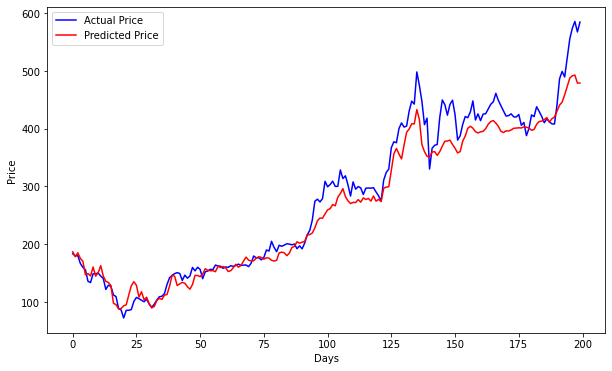

In [66]:
plt.figure(figsize=(10, 6))

plot_graph(model, data)

In [67]:
def get_accuracy(model, data):
    y_test = data["y_test"]
    X_test = data["X_test"]
    y_pred = model.predict(X_test)
    y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
    y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    print(y_test)
    y_pred = list(map(lambda current, future: int(float(future) > float(current)), y_test[:-LOOKUP_STEP], y_pred[LOOKUP_STEP:]))
    y_test = list(map(lambda current, future: int(float(future) > float(current)), y_test[:-LOOKUP_STEP], y_test[LOOKUP_STEP:]))
    return accuracy_score(y_test, y_pred)

In [68]:
print(str(LOOKUP_STEP) + ":", "Accuracy Score:", get_accuracy(model, data))

10: Accuracy Score: 0.6627450980392157
